# Importing the necessary modules

In [126]:
# Utilitaries
from csv import reader
import re
import pandas as pd
import zeep
# Data preparation and text manipulation
import nltk
from nltk.corpus import stopwords as stp
import nltk.stem.snowball as snowball
# Machine learning tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Machine learning classificators
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# Machine learning model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

# Reading the corpus

In [2]:
df = pd.read_csv('corpus.csv')

In [3]:
df.sample(5)

,author,title,translation,label
76,Eftimie,BOR a cerut 1 miliard de dolari de la NASA ca ...,Echipajul va avea la el o candelă și un busuio...,0
930,TVR,"Ludovic Orban, despre demisie: Am considerat c...",Întrebat dacă preşedintele Klaus Iohannis i-a ...,1
970,TVR,Alegătorii din satele izolate vor să nu fie i...,"Cândva, pe ulițe se auzeau voci de copii. Acum...",1
866,TVR,"Negocierile pentru noile funcții, pe final. Pr...","Potrivit unor surse, liberalii ar urma să prei...",1
312,TNR,Costumul de tufiş cu care pândea Arafat români...,"„Mi-am dat seama prea târziu că ăla e un om, n...",0


# Data preparation

### Lemmatization
_Source: http://nlptools.info.uaic.ro/WebPosRo/_

In [4]:
wsdl = 'http://nlptools.info.uaic.ro/WebPosRo/PosTaggerRoWS?wsdl'

In [5]:
client = zeep.Client(wsdl=wsdl)

#### Transforming each article using the POS tagger,tokenizing and filtering the stopwords at the same time

In [6]:
lemmatized_articles_xml=[]

In [7]:
for article in df['translation']:
     lemmatized_articles_xml.append(client.service.parseSentence_XML(article))
    

In [8]:
# # Saving the articles to save execution time
# for article in lemmatized_articles_xml:
#     with open('lemmatized_articles','a+') as f:
#         f.write(article)
#         f.write('\n')

In [9]:
stopwords = stp.words('romanian')
lemmatized_articles_clean=[]
for article in lemmatized_articles_xml:
    article = article.split('\n')
    lemmas = []
    for line in article:
        found = re.search('.*LEMMA="([A-Za-zăâîșț1-9]*)".*', line)
        if found:
            word = found.group(1)
            if word not in stopwords:
                lemmas.append(word)
    lemmatized_articles_clean.append(lemmas)

#### Adding the lemmatized articles to the corpus

In [10]:
df['lemmatized_articles'] = lemmatized_articles_clean

In [11]:
df.sample(5)

,author,title,translation,label,lemmatized_articles
129,Vasile,Un român ambiţios şi-a făcut un pepene acasă d...,„Mai aştept luna plină ca să-i dau viaţă creaţ...,0,"[aștepta, lună, plin, viață, creație, sine, lă..."
529,Calin,Colțescu și-a învățat lecția: „Îi urez succes ...,"„Am evoluat mult de când iau meditații“, se la...",0,"[evolua, lua, meditație, sine, lăuda, Sebastia..."
200,Eftimie,Branșat la contracte cu statul! Dan Bittman va...,"„Decizia a fost luată la nivelul ministerului,...",0,"[decizie, luat, nivel, minister, ști, băga, no..."
96,Eftimie,"Elon Musk, devastat! O pisică spaţială i-a dăr...","China a anunțat că e dispusă să ajute, respect...",0,"[China, anunța, dispus, ajuta, respectiv, crea..."
229,Ionut,"Andi Moisescu, prins de Olivia Steer cu o șaor...","În consecință, Andi nu mai are voie să meargă ...",0,"[andi, voie, merge, român, talent, vrea, parti..."


#### Stemming

In [12]:
stemmed_articles = []
stemmer = snowball.SnowballStemmer('romanian')

for article in df['lemmatized_articles']:
    stemmed_words =[]
    for word in article:
        stemmed_words.append(stemmer.stem(word))
        # Appending the string form of the stemmed array because it will
        # be needed in the next step
    stemmed_articles.append(' '.join(stemmed_words))

#### Adding the stemmed articles to the corpus

In [13]:
df['stemmed_articles']=stemmed_articles

In [14]:
df.sample(5)

,author,title,translation,label,lemmatized_articles,stemmed_articles
162,Calin,"Strehaia va lansa o căruță în spațiu, ca să fu...",Primarul din Strehaia râde de întreprinzător ș...,0,"[primar, Strehaia, râde, întreprinzător, și, n...",primar strehai râd întreprinz și niciun șans s...
267,Ionut,"Turiști fugăriți de Olivia Steer, care încerca...",Olivia a devenit agresivă atunci când un turis...,0,"[olivia, deveni, agresiv, turist, spune, sine,...",oliv deven agres turist spun sin duc teor înar...
129,Vasile,Un român ambiţios şi-a făcut un pepene acasă d...,„Mai aştept luna plină ca să-i dau viaţă creaţ...,0,"[aștepta, lună, plin, viață, creație, sine, lă...",aștept lun plin viaț creaț sin lăud marceleanu...
32,Eftimie,"Azi toți bugetarii sunt la birou, că vin Samsu...",Până la începutul verii nu se așteaptă la un n...,0,"[început, vară, sine, aștepta, vârf, bugetar, ...",încep var sin aștept vârf bugetar munc veder m...
417,Vasile,Smart! Autostrada Moldovei va avea 3 benzi spr...,"„De regulă, dacă ai geacă de blugi şi ştii ole...",0,"[regulă, geacă, blugi, și, ști, oleacî, di, ba...",regul geac blug și ști oleacî di batai duc buc...


# Preparation for the Machine Learning training

#### Extracting the article labels

In [15]:
label = df.label

#### Splitting the dataset

In [82]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

#### Preparing the tokenizer

In [83]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Trying different Machine Learning models

## Bayes Naive

### BN with TF-IDF

In [84]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [85]:
##### _After each transformation its necessary to recompute X_train and X_test again.

In [86]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)

GaussianNB()

In [87]:
y_pred = nb_classifier.predict(X_test)

In [88]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 87.25%
Recall: 65.22%
loss: 4.4


### BN with Count-Vectorizer

In [89]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [90]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [91]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)

GaussianNB()

In [92]:
y_pred = nb_classifier.predict(X_test)

In [93]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 84.8%
Recall: 61.84%
loss: 5.25


## Logistic Regression 

### LR with TF-IDF

In [94]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [95]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [96]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)

LogisticRegression()

In [97]:
y_pred = nb_classifier.predict(X_test)

In [98]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 98.04%
Recall: 94.74%
loss: 0.68


### LR with Count-Vectorizer

In [99]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [100]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [101]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)

LogisticRegression()

In [102]:
y_pred = lr_classifier.predict(X_test)

In [103]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 90.2%
Recall: 90.54%
loss: 3.39


## SGD 

### SGD with TF-IDF

In [104]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [105]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [106]:
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train,y_train)

SGDClassifier()

In [107]:
y_pred = nb_classifier.predict(X_test)

In [108]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 94.12%
Recall: 83.78%
loss: 2.03


### SGD with Count-Vectorizer

In [145]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [146]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [147]:
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train,y_train)

SGDClassifier()

In [148]:
y_pred = lr_classifier.predict(X_test)

In [149]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 97.55%
Recall: 98.68%
loss: 0.85


## Passive Agressive Classifier

### PAC with TF-IDF

In [114]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [115]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [116]:
pac_classifier = PassiveAggressiveClassifier()
pac_classifier.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [117]:
y_pred = nb_classifier.predict(X_test)

In [118]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 98.04%
Recall: 95.06%
loss: 0.68


### PAC with Count-Vectorizer

In [119]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [120]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [121]:
pac_classifier = PassiveAggressiveClassifier()
pac_classifier.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [122]:
y_pred = lr_classifier.predict(X_test)

In [123]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 97.55%
Recall: 97.22%
loss: 0.85


# Statistics for the best performing model

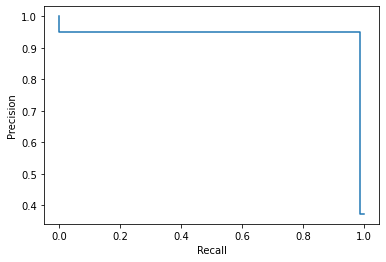

In [150]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


# Testing the SGD model on unseen articles

In [160]:
# Entering the article
article_body = "Putin joaca alba neagra"
# Lemmatizing the article
lemmatized_article = client.service.parseSentence_XML(article_body)
# Cleaning the article
lemmatized_article = lemmatized_article.split('\n')
lemmas = []
for line in lemmatized_article:
    found = re.search('.*LEMMA="([A-Za-zăâîșț1-9]*)".*', line)
    if found:
        word = found.group(1)
        if word not in stopwords:
            lemmas.append(word)
# Stemming the article
stemmed_words =[]
for word in lemmas:
    stemmed_words.append(stemmer.stem(word))
processed_article = ' '.join(stemmed_words)

In [159]:
processed_article

'silv davidoiu acredit ambasador extraordinar și plenipotențiar român reședinț belgrad ana voicu republ oriental uruguay reședinț montevideo simon mirel miculescu delegaț permanent român unesco paris mate viorel ardeleanu deven ambasador extraordinar și plenipotențiar român muntenegru reședinț'